# Arabic Handwritten Characters recognition

   ## Importing the necessary libraries


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tflearn.data_utils as du
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix


## Loading the dataset

In [57]:
train_data = pd.read_csv('./dataset/csvTrainImages 13440x1024.csv', header = None)
train_label = pd.read_csv('./dataset/csvTrainLabel 13440x1.csv', header = None)
test_data = pd.read_csv('./dataset/csvTestImages 3360x1024.csv', header = None)
test_label = pd.read_csv('./dataset/csvTestLabel 3360x1.csv', header = None)


In [58]:
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

In [59]:
train_data[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## Visualizing the dataset

In [60]:
def row_calc(numOfImage, numOfCols):
    if numOfImage % numOfCols != 0:
        return (numOfImage / numOfCols) +1
    else :
        return (numOfImage / numOfCols) + 1

In [61]:
def disply_image(x, imgSize, numOfImages):
    plt.figure(figsize = (8,7))
    if x.shape[0] > 0 : 
        n_sample = x.shape[0]
        x = x.reshape(n_sample, imgSize, imgSize)
        numOfRows = row_calc(numOfImages, 4)
        for i in range(numOfImages):
            plt.subplot(numOfRows, 4, i+1)
            plt.imshow(x[i])

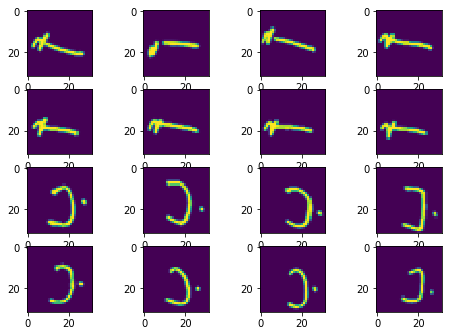

In [62]:
disply_image(train_data, 32, 16)

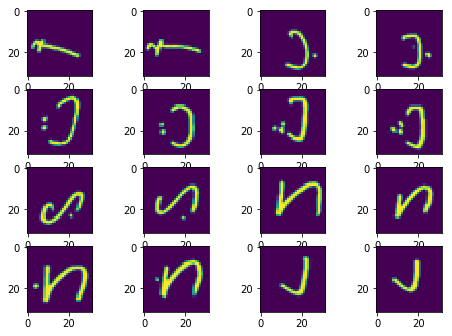

In [63]:
disply_image(test_data, 32, 16)

## Data preprocessing 
###  Encoding categorical variables

In [64]:
train_label = du.to_categorical(train_label,28)

### Normalizarion

In [65]:
train_data = train_data/255
test_data = test_data/255

In [66]:
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

In [67]:
print(train_data.shape)
test_data.shape


(13440, 32, 32, 1)


(3360, 32, 32, 1)

In [68]:
train_data, mean1 = du.featurewise_zero_center(train_data)
test_data, mean2 = du.featurewise_zero_center(test_data)

## Building the CNN


In [69]:
recognizer = Sequential()

recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))

### A summary of the CNN


In [70]:
recognizer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [71]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [72]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [73]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [74]:
datagen.fit(train_data)


## Fitting the CNN to the training data

In [ ]:
recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),epochs = 30, verbose = 2, steps_per_epoch=train_data.shape[0] // 100)

## 